In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [6]:
class dataset(Dataset):
    def __init__(self, dir_path, csv_file,transform=None):
        super(Dataset, self).__init__()

        self.dir_path = dir_path
        self.csv_file = pd.read_csv(csv_file,index_col=0)

        self.input = self.csv_file['x']
        self.output = self.csv_file['y']


        self.transform = transform

    def __len__(self):
        return self.csv_file.shape[0]
        
    def __getitem__(self, index):

        # X 
        x = self.input.iloc[index]
        y = self.output.iloc[index]

        wave_input = cv2.imread(self.dir_path + x, cv2.IMREAD_UNCHANGED)[None, :, :]
        wave_output = cv2.imread(self.dir_path + y, cv2.IMREAD_UNCHANGED)[None, :, :]
        if self.transform:
            wave_input = self.transform(wave_input)
            wave_output = self.transform(wave_output)

        sample = {"wave_input": wave_input,
                    "wave_input_label":index,
                    "wave_output": wave_output,
                    "wave_output_label":index+1,}
        return sample

In [7]:
class Autoencoder(torch.nn.Module): 
    def __init__(self): 
        super(Autoencoder, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=4, stride=2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2),
        )

        self.decoder = torch.nn.Sequential( 
            torch.nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=5, stride=2),
            torch.nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=5, stride=2),
            torch.nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=4, stride=2)
        )

    def forward(self, x):
        x = self.encoder(x)

        x = self.decoder(x)
        return x

In [8]:
PATH = 'Encoder_Decoder_1000.pt'

In [9]:
model = Autoencoder()
model.load_state_dict(torch.load(PATH))
model.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2))
    (1): ConvTranspose2d(64, 32, kernel_size=(5, 5), stride=(2, 2))
    (2): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2))
  )
)

In [11]:
test_data = dataset('Simple_Homogeneous_Moseley/','Simple_Homogeneous_Moseley_Event0000.csv')

In [77]:
# Predicitons

first_wavefield = 10
sample = training_data.__getitem__(first_wavefield)
inputs = torch.tensor(sample['wave_input'])[None]

outputs = []
for _i in range(training_data.__len__()-first_wavefield):

    output = model(inputs)
    outputs.append(output.cpu().detach().numpy()[0,0])

    inputs = output

ipykernel_launcher:20: UserWarning: Use the colorbar set_ticks() method instead.


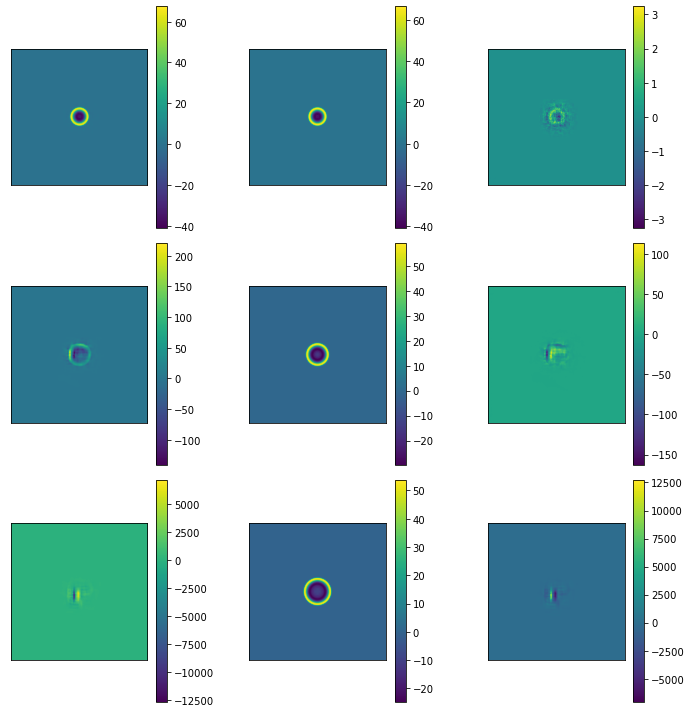

In [82]:
test_outputs = [0,5,10]

fig , axs = plt.subplots(3,len(test_outputs), figsize=(10,10))

for i, ts in enumerate(test_outputs):

    preds = outputs[ts]
    true = training_data.__getitem__(first_wavefield+ts)['wave_output'][0]
    error = true-preds
    im_pred = axs[i,0].imshow(preds)
    plt.colorbar(im_pred, ax=axs[i,0])

    im_true = axs[i,1].imshow(true)
    plt.colorbar(im_true, ax=axs[i,1])

    im_err = axs[i,2].imshow(error)
    plt.colorbar(im_err, ax=axs[i,2])

plt.tight_layout()
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
plt.show()

In [101]:
# See line plot input - output 
wave_in = training_data.__getitem__(first_wavefield)['wave_input'][0][150,:]
wave_out = training_data.__getitem__(first_wavefield)['wave_output'][0][150,:]
pred_out = outputs[0][150,:]

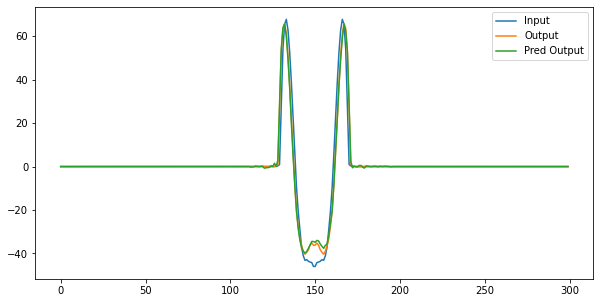

In [102]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(wave_in,label='Input')
ax.plot(wave_out,label='Output')
ax.plot(pred_out, label='Pred Output')
plt.legend()

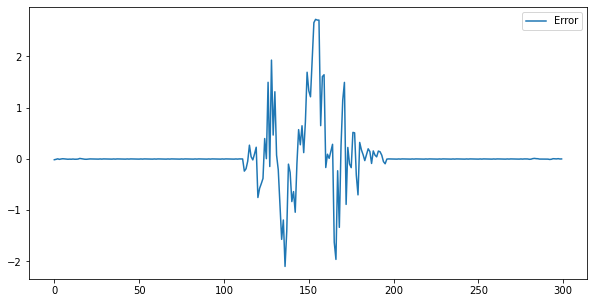

In [105]:
fig, ax = plt.subplots(figsize=(10,5))
#ax.plot(wave_out-wave_in,label='Error')
ax.plot(pred_out-wave_out,label='Error')
plt.legend()